In [1]:
import pandas as pd
import numpy as np
import os

train_data_path = "./data/train/audio/"
test_data_path = "./data/test/audio/"

In [2]:
train_labels = 'yes no up down left right on off stop go silence unknown'.split()

# 1. Helper functions

In [61]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [62]:
def list_wavs_fname_train(dirpath, ext='wav'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

def list_wavs_fname_test(dirpath, ext='wav'):
    fnames = glob(os.path.join(dirpath, r'*' + ext))
    return fnames

In [63]:
def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in train_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return nlabels

# 2. Importing train dataset

In [64]:
from glob import glob
import gc
import re
from scipy.io import wavfile
from scipy import signal
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt

In [65]:
labels, fnames = list_wavs_fname_train(train_data_path)

./data/train/audio/


In [66]:
i = 5000
label, fname = labels[i], fnames[i]

one


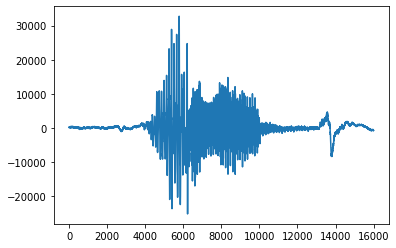

In [67]:
sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
plt.plot(samples)
print(label)
plt.show()

In [68]:
samples = pad_audio(samples)

In [69]:
new_sample_rate = 8000

if len(samples) > 16000:
    n_samples = chop_audio(samples)
    print(label)
else: n_samples = [samples]
for samples in n_samples:
    resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
    freqs, times, specgram = log_specgram(resampled, sample_rate=new_sample_rate)

In [70]:
samples

array([ 126,  264,  265, ..., -791, -725, -756], dtype=int16)

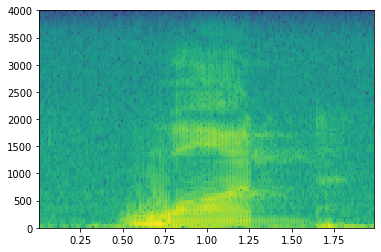

In [71]:
plt.specgram(samples, NFFT=200, Fs=new_sample_rate)
plt.show()

In [6]:
L = 16000
new_sample_rate = 8000
y_train = []
x_train = []



for label, fname in zip(labels, fnames):
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
        print(label)
    else: n_samples = [samples]
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        y_train.append(label)
        x_train.append(specgram)
x_train = np.array(x_train)
x_train = x_train.reshape(tuple(list(x_train.shape) + [1]))

ohc = OneHotEncoder()
y_train = label_transform(y_train)

y_train = np.array(y_train).reshape(-1, 1)

ohc.fit(y_train)

y_train = ohc.transform(y_train)

y_train = y_train.toarray()

del labels, fnames
gc.collect()

NameError: name 'labels' is not defined

# 3. Training model

In [9]:
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
#import keras
import tensorflow as tf

In [10]:
input_shape = (99, 81, 1)
nclass = 12
inp = Input(shape=input_shape)
norm_inp = BatchNormalization()(inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(norm_inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(img_1)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Flatten()(img_1)

dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

model = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['accuracy'])
model.summary()

model.fit(x_train, y_train, batch_size=32, epochs=4, shuffle=True)

model.save(os.path.join('./models', 'cnn_model_best'))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 99, 81, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 81, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 80, 8)         40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 79, 8)         264       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 78, 8)         264       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 39, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 39, 8)         0     

# 4. Cleaning memory

In [11]:
del x_train, y_train
gc.collect()

20

# 5. Importing test dataset

In [12]:
fnames = list_wavs_fname_test(test_data_path)

In [13]:
L = 16000
new_sample_rate = 8000
x_test = []

for fname in fnames:
    sample_rate, samples = wavfile.read(fname)
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
    else: n_samples = [samples]
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        x_test.append(specgram)
x_test = np.array(x_test)
x_test = x_test.reshape(tuple(list(x_test.shape) + [1]))
del fnames
gc.collect()

0

In [14]:
y_test = model.predict(x_test)

In [15]:
del x_test
gc.collect()

705

In [16]:
fnames = list_wavs_fname_test(test_data_path)
filenames = [x.split('/')[-1] for x in fnames]

In [17]:
y_pred = ohc.inverse_transform(y_test)

In [18]:
kaggle_df = pd.DataFrame()

In [19]:
kaggle_df['fname'] = filenames

In [20]:
kaggle_df['label'] = y_pred

In [21]:
kaggle_df.to_csv('kaggle_cnn_best.csv', index=False, header=True, quoting=0)

In [23]:
np.unique(y_pred, return_counts=True)

(array(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence',
        'stop', 'unknown', 'up', 'yes'], dtype='<U7'),
 array([  3470,   6608,   4083,   6474,   7022,   6025,   6100,   2171,
          4090, 104078,   3667,   4750]))